In [2]:
import os
import json
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
import numpy as np

import matplotlib.pyplot as plt

import pytorch_lightning as pl

random_seed = 1337
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
train_ratio = 0.8  # 80% for training, 20% for validation

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

print(NUM_WORKERS)

8


In [3]:
json_dir = '../learning-data/'

all_segments = []
all_grass_positions = []
all_starting_points = []

# Helper function to compute length and angle
def compute_length_and_angle(x1, y1, x2, y2):
    length = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    angle = np.arctan2(y2 - y1, x2 - x1)
    return length, angle

# Iterate through JSON files
for filename in os.listdir(json_dir):
    if filename.endswith('.json'):
        with open(os.path.join(json_dir, filename), 'r') as f:
            ground_data = json.load(f)
            segments = ground_data['segments']
            grass_positions = ground_data['grassPositions']
            # check if ground data contains starting point
            if 'startingPoint' in ground_data:
                starting_point = ground_data['startingPoint']
            else:
                starting_point = all_starting_points[-1]

            # Append data to lists
            all_segments.append(segments)
            all_grass_positions.append(grass_positions)
            all_starting_points.append(starting_point)

In [4]:
segments_list = []
for segment in all_segments:
    #segment_tensor = torch.tensor([[point['x'], point['y'], point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    #segment_tensor = torch.tensor([[point['x'], point['y']] for point in segment], dtype=torch.float32)
    segment_tensor = torch.tensor([[point['length'], point['angleToNextVector']] for point in segment], dtype=torch.float32)
    segments_list.append(segment_tensor)
segments_tensor = torch.stack(segments_list)

# Convert grass positions to tensor
grass_positions_tensor = torch.tensor(all_grass_positions, dtype=torch.int64)  # Assuming grass positions are integers

# Convert starting points to tensor
starting_points_tensor = torch.tensor(all_starting_points, dtype=torch.float32)


In [5]:
train_size = int(len(segments_tensor) * train_ratio)  # % for training
val_size = len(segments_tensor) - train_size  # Remaining % for validation

# Split the data into training and validation sets
train_dataset, val_dataset = random_split(segments_tensor, [train_size, val_size])

# Create DataLoader instances for training and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Optionally, you can print the sizes of the datasets
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

Training dataset size: 403
Validation dataset size: 101


In [6]:
# Define the discriminator model
class FNNDiscriminator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FNNDiscriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Define the generator model
class LSTMGenerator(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(LSTMGenerator, self).__init__()
        self.hidden_size1 = hidden_size1
        self.lstm = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.fc1 = nn.Linear(hidden_size1, hidden_size2)
        self.fc2 = nn.Linear(hidden_size2, hidden_size3)
        self.fc3 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        
        out = out[:, -1, :]  # Take the output from the last time step
        
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out


In [46]:

# Define hyperparameters
input_size_discriminator = 1710  # Input size should match the length of each segment for x and y only
hidden_size_discriminator1 = 256
hidden_size_discriminator2 = 128
hidden_size_discriminator3 = 64
output_size_discriminator = 1

input_size_generator = 32
hidden_size_generator1 = 64
hidden_size_generator2 = 256
hidden_size_generator3 = 512
output_size_generator = 1710  # Output size should match the size of each segment for x and y only

discriminator = FNNDiscriminator(input_size_discriminator, hidden_size_discriminator1,
                                  hidden_size_discriminator2, hidden_size_discriminator3,
                                  output_size_discriminator)
generator = LSTMGenerator(input_size_generator, hidden_size_generator1, hidden_size_generator2, hidden_size_generator3, output_size_generator)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0003, betas=(0.55, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0004, betas=(0.55, 0.999))

# Define the length penalty loss function
def length_penalty_loss(flat_fake_data, batch_size):
    lengths = flat_fake_data.view(batch_size, -1, 2)[:, :, 0]  # Extract length values
    penalty = torch.sum(torch.relu(-lengths))  # Penalize negative length values
    return penalty

def angle_loss(angles):
    # Compute the absolute difference between angles and the horizontal direction (0 degrees)
    horizontal_angles = torch.zeros_like(angles)  # Horizontal direction (0 degrees)
    angle_diff = torch.abs(angles - horizontal_angles)
    
    # Penalize angles that deviate too much from the horizontal direction
    max_deviation_deg = 60  # Maximum allowed deviation from horizontal (10 degrees)
    max_deviation_rad = torch.deg2rad(torch.tensor(max_deviation_deg))  # Convert degrees to radians
    angle_penalty = torch.relu(angle_diff - max_deviation_rad)
    
    # Sum up the penalties for all angles
    total_penalty = torch.sum(angle_penalty)
    
    return total_penalty



# Training loop
num_epochs = 300
lambda_penalty = 10.0  # Weight for the length penalty loss
lambda_angle = 10.0  # Weight for the angle loss


for epoch in range(num_epochs):
    for real_data in train_dataloader:
        real_labels = torch.ones(len(real_data), 1)
        fake_labels = torch.zeros(len(real_data), 1)

        real_data = real_data.float().view(real_data.size(0), -1)  # Flatten the input data

        real_output = discriminator(real_data)
        d_loss_real = criterion(real_output, real_labels)
        real_score = real_output

        z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
        fake_data = generator(z)
        fake_data = fake_data.view(fake_data.size(0), -1)  # Flatten the fake data

        fake_output = discriminator(fake_data)
        d_loss_fake = criterion(fake_output, fake_labels)
        fake_score = fake_output

        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train generator
        z = torch.randn(len(real_data), input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
        fake_data = generator(z)
        output = discriminator(fake_data.view(fake_data.size(0), -1))  # Flatten the fake data

        g_loss = criterion(output, real_labels)

        # Add the length penalty loss
        length_penalty = length_penalty_loss(fake_data, len(real_data))
        
        # Compute the angle loss
        angles = fake_data.view(len(real_data), -1, 2)[:, :, 1]  # Extract angles
        angle_loss_value = angle_loss(angles)

        # Calculate the total generator loss
        total_g_loss = g_loss + lambda_penalty * length_penalty + lambda_angle * angle_loss_value

        g_optimizer.zero_grad()
        total_g_loss.backward()
        g_optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {total_g_loss.item():.4f}, length_penalty: {length_penalty.item():.4f}, angle_loss: {angle_loss_value.item():.4f}')

# After training, generate new fake data
z = torch.randn(1, input_size_generator).unsqueeze(1).repeat(1, 855, 1)  # Generate random noise
fake_data = generator(z)
fake_data = fake_data.view(fake_data.size(0), 855, 2)

generated_data = []

for sample in fake_data:
    segment_data = []
    for vector in sample:
        segment_data.append({
            "length": vector[0].item(),
            "angleToNextVector": vector[1].item()
        })
    generated_data.append({"segments": segment_data})

print(generated_data)

Epoch [1/300], d_loss: 0.7871, g_loss: 1117.2719, length_penalty: 111.6574, angle_loss: 0.0000
Epoch [2/300], d_loss: 0.7075, g_loss: 253.7059, length_penalty: 25.3014, angle_loss: 0.0000
Epoch [3/300], d_loss: 0.7090, g_loss: 20.6368, length_penalty: 1.9948, angle_loss: 0.0000
Epoch [4/300], d_loss: 0.7026, g_loss: 4.7241, length_penalty: 0.4029, angle_loss: 0.0000
Epoch [5/300], d_loss: 0.6913, g_loss: 2.2969, length_penalty: 0.1593, angle_loss: 0.0000
Epoch [6/300], d_loss: 0.6811, g_loss: 1.4931, length_penalty: 0.0781, angle_loss: 0.0000
Epoch [7/300], d_loss: 0.6734, g_loss: 1.2750, length_penalty: 0.0555, angle_loss: 0.0000
Epoch [8/300], d_loss: 0.6644, g_loss: 1.1050, length_penalty: 0.0376, angle_loss: 0.0000
Epoch [9/300], d_loss: 0.6560, g_loss: 1.0734, length_penalty: 0.0337, angle_loss: 0.0000
Epoch [10/300], d_loss: 0.6470, g_loss: 1.2176, length_penalty: 0.0472, angle_loss: 0.0000
Epoch [11/300], d_loss: 0.6375, g_loss: 1.1916, length_penalty: 0.0433, angle_loss: 0.0000

sample {'segments': [{'length': 0.024873927235603333, 'angleToNextVector': 0.3531227707862854}, {'length': 0.015447776764631271, 'angleToNextVector': 0.19527088105678558}, {'length': 0.022266898304224014, 'angleToNextVector': 0.057656899094581604}, {'length': 0.0121984351426363, 'angleToNextVector': -0.651890754699707}, {'length': 0.023294219747185707, 'angleToNextVector': 0.3865884840488434}, {'length': 0.013929312117397785, 'angleToNextVector': 0.16492222249507904}, {'length': 0.02115393988788128, 'angleToNextVector': 0.1872204840183258}, {'length': 0.01834537275135517, 'angleToNextVector': -0.028309952467679977}, {'length': 0.016050150617957115, 'angleToNextVector': -0.65870201587677}, {'length': 0.012205233797430992, 'angleToNextVector': -0.6281710267066956}, {'length': 0.010674260556697845, 'angleToNextVector': -0.0499991774559021}, {'length': 0.01568698137998581, 'angleToNextVector': -0.7399284243583679}, {'length': 0.02164270356297493, 'angleToNextVector': 0.28383636474609375}, 

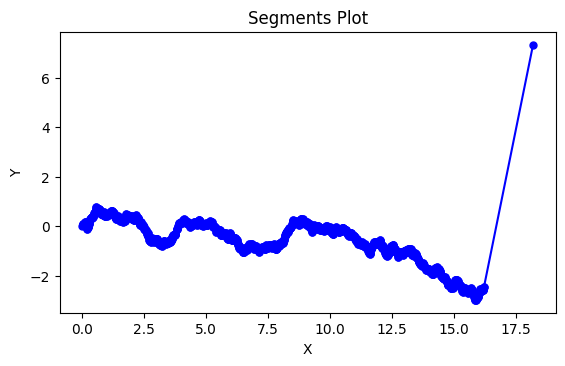

In [50]:
def plot_segments_from_json(data):
    fig, ax = plt.subplots()
    
    for sample in data:
        print("sample", sample)
        segments = sample["segments"]
        x, y = 0, 0  # Starting point
        
        for segment in segments:
            length = segment["length"]
            tmpangle = segment["angleToNextVector"]
            if tmpangle < 0:
                tmpangle = tmpangle + 360
            angle = np.radians(segment["angleToNextVector"])  # Convert angle to radians

            new_x = x + length * np.cos(angle)
            new_y = y + length * np.sin(angle) * 500
            
            # Plot a line segment from (x, y) to (new_x, new_y)
            ax.plot([x, new_x], [y, new_y], 'bo-', markersize=5)  # 'bo-' for blue line with circle markers

            # Update the current point
            x, y = new_x, new_y

    ax.set_aspect('equal', 'box')
    ax.autoscale()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Segments Plot')
    plt.show()

# Example usage:
plot_segments_from_json(generated_data)


